In [1]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

In [2]:
import numpy as np
import pdb

# my code
from distribution import RBMLatentPosterior, MultivariateBernoulliNoise
from latent_nce_optimiser import LatentNCEOptimiser
from latent_variable_model import RestrictedBoltzmannMachine

from matplotlib import pyplot as plt
from matplotlib import rc
from numpy import random as rnd

%matplotlib inline
rc('lines', linewidth=3)
rc('font', size=18)
rc('legend', fontsize=18)

# For reproducibility
rng = rnd.RandomState(1083463236)

In [3]:
n = 10000 # number of datapoints
nz = 10  # number latent samples per datapoint
nu = 10

d = 2  # visible dimension
m = 1  # latent dimension
"""true_W = np.array([[0, 0.1, 0.2],
                  [-1, -0.3, 0.4],
                  [1, -0.5, 0.6], 
                  [0, -0.7, 0.8]])"""

true_W = np.array([[0, 0.4],
                   [-0.5, 0.6], 
                   [-0.7, 0.8]])
#theta0 = true_W
theta0 = rnd.uniform(-0.1, 0.1, (d+1, m+1))

In [4]:
true_data_dist = RestrictedBoltzmannMachine(true_W)
X, Z = true_data_dist.sample(n, num_iter=10000)

In [5]:
X_mean = np.mean(X, axis=0)
X_centred = X - X_mean
X_cov = (1/n)*np.dot(X_centred.T, X_centred)

In [6]:
model = RestrictedBoltzmannMachine(theta0)

In [7]:
noise = MultivariateBernoulliNoise(X_mean)  # uniform dist over binary vectors i.e p(u) = 2**-d
var_dist = RBMLatentPosterior(theta0)

In [8]:
optimiser = LatentNCEOptimiser(model, noise, var_dist, n, nu=nu, latent_samples_per_datapoint=nz)

         Current function value: 3.430746
         Iterations: 3
         Function evaluations: 109
         Gradient evaluations: 97
         Current function value: 3.422526
         Iterations: 0
         Function evaluations: 109
         Gradient evaluations: 97


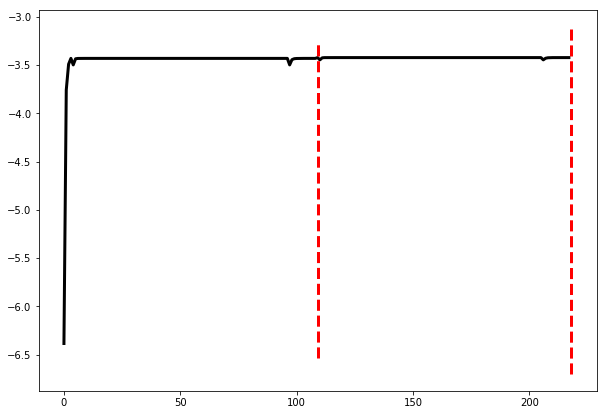

In [9]:
thetas_after_EM_step, J1s, J1_grads = optimiser.fit_using_analytic_q(X, theta0=theta0.reshape(-1), stop_threshold=10**-3)

In [10]:
model.theta.reshape(d+1, m+1)

array([[-1.70639652, -0.21832068],
       [-0.68467632, -0.21027395],
       [ 0.24161886, -0.02415524]])

In [11]:
true_W

array([[ 0. ,  0.4],
       [-0.5,  0.6],
       [-0.7,  0.8]])

In [12]:
print('    ---DATA FROM TRUE DISTRIBUTION---         \n')
for i in range(d):
    print('empirical prob of x_{} being 1 is {}.'.format(i, np.mean(X[:, i])))
print('\n')
for i in range(m):
    print('empirical prob of z_{} being 1 is {}.'.format(i, np.mean(Z[:, i])))

    ---DATA FROM TRUE DISTRIBUTION---         

empirical prob of x_0 being 1 is 0.4867.
empirical prob of x_1 being 1 is 0.4795.


empirical prob of z_0 being 1 is 0.7366.


In [13]:
model_X, model_Z = model.sample(n, num_iter=10000)
print('         ---DATA FROM MODEL---         \n')
for i in range(d):
    print('empirical prob of x_{} being 1 is {}.'.format(i, np.mean(model_X[:, i])))
print('\n')
for i in range(m):
    print('empirical prob of z_{} being 1 is {}.'.format(i, np.mean(model_Z[:, i])))

         ---DATA FROM MODEL---         

empirical prob of x_0 being 1 is 0.3183.
empirical prob of x_1 being 1 is 0.5681.


empirical prob of z_0 being 1 is 0.4339.


In [14]:
print('average value of model on true data: {} \n'
'average value of model on model data: {}'.format(
      np.mean(model(X, Z.reshape(1, n, -1))), 
      np.mean(model(model_X, model_Z.reshape(1, n, -1)))))

average value of model on true data: 0.12602716912650705 
average value of model on model data: 0.15843899011942972


In [15]:
print('average value of true dist on true data: {} \n'
'average value of true dist on model data: {}'.format(
      np.mean(true_data_dist(X, Z.reshape(1, n, -1))), 
      np.mean(true_data_dist(model_X, model_Z.reshape(1, n, -1)))))

average value of true dist on true data: 1.4105716479335624 
average value of true dist on model data: 1.0583404092292015


In [16]:
Y = optimiser.Y
model.theta = theta0.reshape(-1)
var_dist.alpha = theta0.reshape(-1)
ZX, ZY = var_dist.sample(nz, X), var_dist.sample(nz, Y)
optimiser.compute_J1(X, ZX, ZY)

-6.385514925136358